In [18]:
import pandas as pd
import configparser
import plotly_express as px
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE
config = configparser.ConfigParser()
import sys
config.read("../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']
sys.path.append(local_lib)

OHCO = ['speech_id', 'para_num', 'sent_num', 'token_num']

In [4]:
CORPUS = pd.read_csv('CORPUS.csv', sep='|').set_index(OHCO)
VOCAB = pd.read_csv('VOCAB.csv', sep='|').set_index('term_str')

In [8]:
BAG = OHCO[:2]

docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset='term_str')\
    .groupby(BAG).term_str.apply(lambda x: x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc)>1]

vocab = Dictionary(docs)

In [9]:
w2v_params = dict(window=5, vector_size=246, min_count=100, workers=4)

model = word2vec.Word2Vec(docs, **w2v_params)

In [12]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except:
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
1,-0.264495,-0.081412,-0.079202,0.011987,0.152535,-0.465914,-0.274047,0.314222,-0.305520,0.224944,...,-0.408047,0.340886,-0.093264,-0.268030,0.291284,-0.008810,0.090842,-0.015453,-0.274728,0.077824
10,-0.072171,-0.225071,-0.109617,0.140894,0.225667,-0.282081,-0.233739,0.290182,-0.111907,0.245938,...,-0.280072,0.105725,-0.002353,-0.203260,0.286644,-0.076581,0.161476,0.051552,-0.486568,0.043968
2,-0.127915,-0.332376,-0.120730,0.204912,0.306791,-0.381627,-0.286673,0.383283,-0.122529,0.381324,...,-0.281280,0.069727,0.005072,-0.322306,0.380826,0.003909,0.196851,0.158269,-0.558112,-0.020070
3,-0.071772,-0.335526,-0.043443,0.260545,0.243549,-0.440831,-0.315700,0.313038,-0.280501,0.328960,...,-0.194432,0.065474,-0.041641,-0.323650,0.260415,-0.046628,0.141166,0.119719,-0.411700,0.012719
4,-0.032940,-0.272939,-0.078305,0.184293,0.282984,-0.330393,-0.198022,0.233450,-0.124283,0.244064,...,-0.164356,0.069248,0.032477,-0.244401,0.309729,-0.034022,0.095568,0.091110,-0.410571,0.016833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
years,-0.104018,-0.731938,0.270175,0.496259,0.462158,-0.405696,-0.897432,0.460948,-0.216794,0.734728,...,-0.419171,-0.731289,0.159071,0.138113,-0.293020,-0.460133,0.523840,0.368237,-0.596987,-0.218951
yet,0.309957,0.029926,0.134272,0.226377,-0.070133,0.267984,-0.142452,-0.066611,0.019667,0.051066,...,-0.100584,-0.004375,0.158110,0.244905,0.044072,-0.151483,0.206968,0.105367,0.150428,-0.073473
you,-0.343644,-0.246158,0.085599,-0.467967,-0.452304,-0.030874,0.268060,-0.083788,-0.282242,-0.086190,...,0.359693,-0.209962,0.609713,-0.181225,-0.543411,-0.075280,-0.243537,-0.378358,-0.313927,-0.109677


In [13]:
WV.to_csv('word2vec.csv')

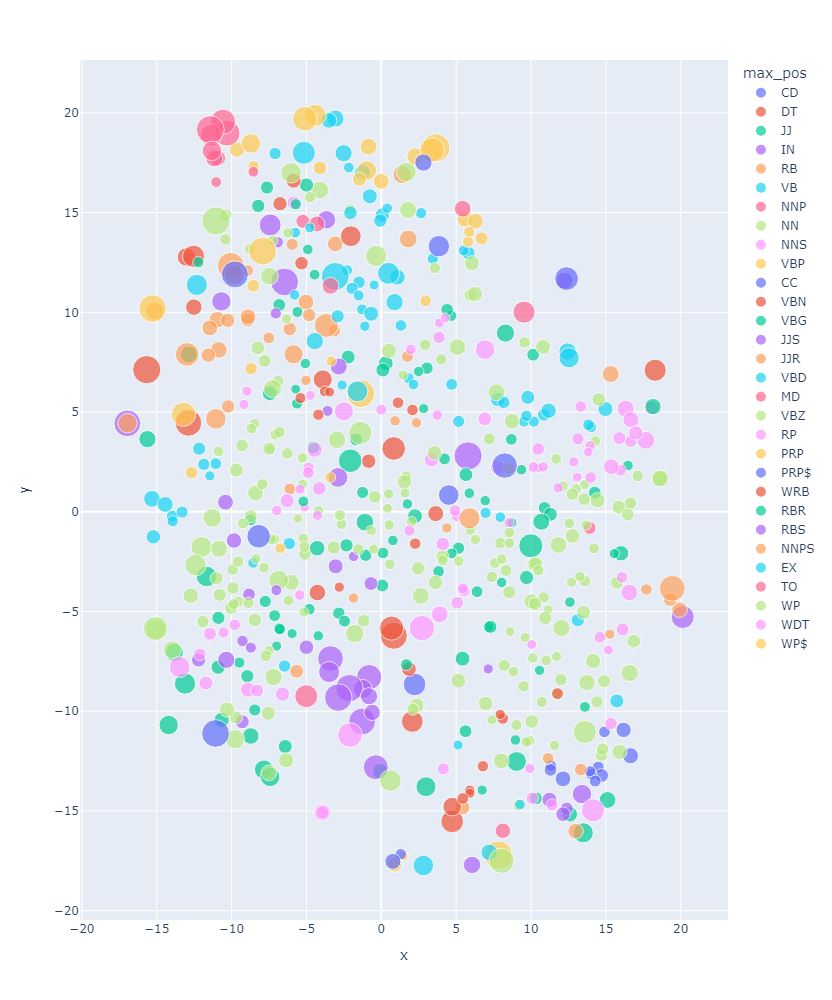

In [24]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=123)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())
TSNE_DF = pd.DataFrame(tsne_model, columns=['x', 'y'], index=WV.index)

X = TSNE_DF.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', color='max_pos', hover_name='term_str', size='dfidf',
          height=1000)

In [23]:
X

,x,y,n,n_chars,p,i,max_pos,max_pos_group,stop,porter_stem,dfidf
term_str,,,,,,,,,,,
1,14.909975,-11.037408,153,1,0.000281,11.795411,CD,CD,0,1,849.661195
10,14.493869,-12.798840,166,2,0.000305,11.677759,CD,CD,0,10,886.348052
2,14.721141,-13.221741,226,1,0.000416,11.232620,CD,CD,0,2,1187.747485
3,14.033045,-13.150812,149,1,0.000274,11.833630,CD,CD,0,3,849.661195
4,13.957908,-13.013397,136,1,0.000250,11.965336,CD,CD,0,4,783.847466
...,...,...,...,...,...,...,...,...,...,...,...
years,14.140800,-14.965424,1251,5,0.002300,8.763933,NNS,NN,0,year,3318.503730
yet,-10.255571,9.598544,260,3,0.000478,11.030431,RB,RB,0,yet,1285.283229
you,3.403789,18.145849,2125,3,0.003907,7.999552,PRP,PR,1,you,3800.963009
